In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2
from cv2 import imread, createCLAHE # read and equalize images

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from skimage.util import montage as montage2d

import os
from glob import glob
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!mkdir /home/TBX11K/MergedBCH

!mkdir /home/TBX11K/MergedBCH/train
!mkdir /home/TBX11K/MergedBCH/val
!mkdir /home/TBX11K/MergedBCH/test

!mkdir /home/TBX11K/MergedBCH/train/sick
!mkdir /home/TBX11K/MergedBCH/train/health
!mkdir /home/TBX11K/MergedBCH/train/tb

!mkdir /home/TBX11K/MergedBCH/val/sick
!mkdir /home/TBX11K/MergedBCH/val/health
!mkdir /home/TBX11K/MergedBCH/val/tb


!mkdir /home/TBX11K/MergedBCH/test/Montgomery
!mkdir /home/TBX11K/MergedBCH/test/Montgomery/health
!mkdir /home/TBX11K/MergedBCH/test/Montgomery/tb
!mkdir /home/TBX11K/MergedBCH/test/Montgomery/sick

!mkdir /home/TBX11K/MergedBCH/test/Shenzhen
!mkdir /home/TBX11K/MergedBCH/test/Shenzhen/health
!mkdir /home/TBX11K/MergedBCH/test/Shenzhen/tb
!mkdir /home/TBX11K/MergedBCH/test/Shenzhen/sick

In [3]:
!mkdir /home/TBX11K/MergedBCH/test/DA_DB
!mkdir /home/TBX11K/MergedBCH/test/DA_DB/health
!mkdir /home/TBX11K/MergedBCH/test/DA_DB/tb
!mkdir /home/TBX11K/MergedBCH/test/DA_DB/sick

In [4]:
from multiprocessing import Pool

def process_merge(res):
    ch1_img = cv2.imread(res['channel1'],cv2.IMREAD_GRAYSCALE)
    ch2_img = cv2.imread(res['channel2'],cv2.IMREAD_GRAYSCALE)
    ch3_img = cv2.imread(res['channel3'],cv2.IMREAD_GRAYSCALE)
    
    merged = cv2.merge([ch1_img,ch2_img,ch3_img])
    dest_file = res['dest_file']
    cv2.imwrite(dest_file,merged)
    return True

def process_image_files(img_files,dest_dir):
    res = []
    for filename in img_files:
        dest_file = os.path.join(dest_dir,os.path.basename(filename))
        row = {'filename':filename,'dest_file':dest_file}
        res.append(row)
    
    workers = os.cpu_count()
    with Pool(workers) as p:
        p.map(process_clahe, res)  

In [5]:
TBX_DIR = '/home/TBX11K'
TBX_DEST_DIR = '/home/TBX11K/MergedBCH'
for split_dir in ['train','val']:
    for class_dir in ['health','sick','tb']:
        
        file_path = os.path.join(TBX_DIR,split_dir,class_dir,'*.png')
        img_files = glob(file_path)
        res = []
        for filename in img_files:
            row = {}
            basename = os.path.basename(filename)
            row['channel1'] = os.path.join(TBX_DIR,'BF',split_dir,class_dir,basename)
            row['channel2'] = os.path.join(TBX_DIR,'CLAHE',split_dir,class_dir,basename)
            row['channel3'] = os.path.join(TBX_DIR,'HEF',split_dir,class_dir,basename)
            row['dest_file'] = os.path.join(TBX_DEST_DIR,split_dir,class_dir,basename)
            res.append(row)
        
        workers = os.cpu_count()
        with Pool(workers) as p:
            p.map(process_merge, res)

#### Merged ORIGINAL+BF+CLAHE

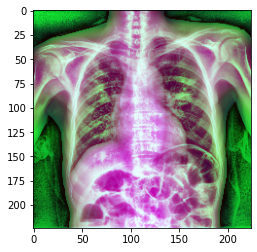

In [6]:
TBX_DIR = '/home/TBX11K'
TBX_DEST_DIR = '/home/TBX11K/MergedBCH'
file_path = os.path.join(TBX_DEST_DIR,'train','tb','*.png')
img_files = glob(file_path)
img = cv2.imread(img_files[0])
plt.imshow(img)

b, g, r = cv2.split(img)

##### BF Image

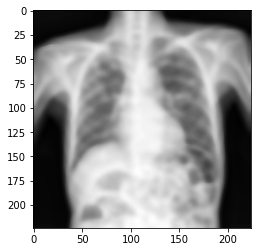

In [7]:
# Displaying Blue channel image
plt.imshow(b,cmap='gray')

##### CLAHE Image

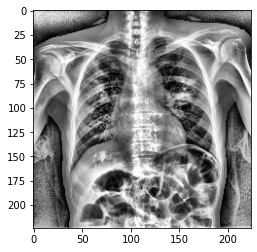

In [8]:
# Displaying Blue channel image
plt.imshow(g,cmap='gray')

##### HEF Image

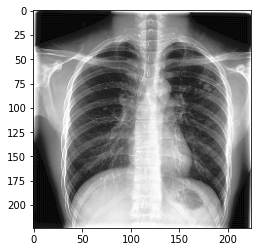

In [11]:
# Displaying Blue channel image
plt.imshow(r,cmap='gray')

In [9]:
TBX_DIR_TEST = '/home/TBX11K'
TBX_DEST_DIR_TEST = '/home/TBX11K/MergedBCH/test'

for split_dir in ['Montgomery','Shenzhen']:
    for class_dir in ['health','sick','tb']:
        file_path = os.path.join(TBX_DIR_TEST,'test',split_dir,class_dir,'*.png')
        img_files = glob(file_path)
        res = []
        for filename in img_files:
            row = {}
            row['channel1'] = filename
            basename = os.path.basename(filename)
            row['channel1'] = os.path.join(TBX_DIR_TEST,'BF/test',split_dir,class_dir,basename)
            row['channel2'] = os.path.join(TBX_DIR_TEST,'CLAHE/test',split_dir,class_dir,basename)
            row['channel3'] = os.path.join(TBX_DIR_TEST,'HEF/test',split_dir,class_dir,basename)
            row['dest_file'] = os.path.join(TBX_DEST_DIR_TEST,split_dir,class_dir,basename)
            res.append(row)
        
        #merge image using multi-processing
        workers = os.cpu_count()
        with Pool(workers) as p:
            p.map(process_merge, res)

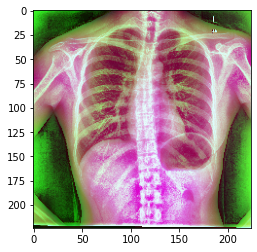

In [10]:
file_path = os.path.join(TBX_DEST_DIR_TEST,'Shenzhen','tb','*.png')
img_files = glob(file_path)
img = cv2.imread(img_files[30])
plt.imshow(img)

b, g, r = cv2.split(img)

In [11]:
TBX_DEST_DIR_TEST = '/home/TBX11K/MergedBCH/test'
data_source = ['Montgomery','Shenzhen']
classes = ['health','tb']
for source in data_source:
    for class_dir in classes:
        img_files = glob(os.path.join(TBX_DEST_DIR_TEST,source,class_dir,"*.png"))
        total = len(img_files)
        mid = total//2
        
        
        print(source,class_dir,len(img_files))

Montgomery health 40
Montgomery tb 29
Shenzhen health 163
Shenzhen tb 168


In [4]:
from multiprocessing import Pool
def process_merge(res):
    ch1_img = cv2.imread(res['channel1'],cv2.IMREAD_GRAYSCALE)
    ch2_img = cv2.imread(res['channel2'],cv2.IMREAD_GRAYSCALE)
    ch3_img = cv2.imread(res['channel3'],cv2.IMREAD_GRAYSCALE)
    
    merged = cv2.merge([ch1_img,ch2_img,ch3_img])
    dest_file = res['dest_file']
    cv2.imwrite(dest_file,merged)
    
    for i in range(4):
        basename = os.path.basename(dest_file)
    return True

In [5]:
TBX_DIR_TEST = '/home/TBX11K'
TBX_DEST_DIR_TEST = '/home/TBX11K/MergedBCH/test'

ctr = 1
for split_dir in ['DA_DB']:
    for class_dir in ['tb']:
        file_path = os.path.join(TBX_DIR_TEST,'test',split_dir,class_dir,'*.png')
        img_files = glob(file_path)
        res = []
        for filename in img_files:

            row = {}
            row['channel1'] = filename
            basename = os.path.basename(filename)
            row['channel1'] = os.path.join(TBX_DIR_TEST,'BF/test',split_dir,class_dir,basename)
            row['channel2'] = os.path.join(TBX_DIR_TEST,'CLAHE/test',split_dir,class_dir,basename)
            row['channel3'] = os.path.join(TBX_DIR_TEST,'HEF/test',split_dir,class_dir,basename)
            
            for i in range(4):
                ctr += 1
                os_string = 'oversample_mcs_'+str(ctr)+'_'
                os_name = os_string+basename
                row['dest_file'] = os.path.join(TBX_DEST_DIR_TEST,split_dir,class_dir,basename)
            res.append(row)
        
        #merge image using multi-processing
        workers = os.cpu_count()
        with Pool(workers) as p:
            p.map(process_merge, res)